In [ ]:
import numpy as np
import csv
from matplotlib import pyplot as plt
import scipy.stats as stats
from IPython.core.pylabtools import figsize
from nipy import load_image, save_image
from nipy.core.api import Image
import pymc3 as pm
import theano.tensor as T
%pylab inline

In [2]:
### Generate data 

def get_data(nii_file):
    image = load_image(nii_file)
    return image.get_data()

def subject_noise(tract, tau):
    noise = stats.norm.rvs(0, tau, size=tract.shape)  
    return tract + noise

def generate_additive(gamma, tau):
    ## tau == standard deviation (not variance or 1/t)
    return stats.norm.rvs(gamma, tau)
     
def generate_multiplicative(lamb, theta):
    return stats.gamma.rvs(lamb, scale=theta)
    
def generate_noise(tau):
    ## tau == standard deviation (not variance or 1/t)
    return stats.norm.rvs(0, tau)

#Assume uniform scanner noise along tract
def add_noise(tract_profile, scanner):
    additive = generate_additive(scanner["gamma"], scanner["tau"]) 
    multiplicative = generate_multiplicative(scanner["lamb"], scanner["theta"]) 
#    print("Additive: {0}".format(additive))
#    print("Mult: {0}".format(multiplicative))
    return np.clip((tract_profile * multiplicative + additive), 0, 1)



In [3]:
#Generate data
scanner_list = ["scanner1", "scanner2"]

scanner_pars = {"scanner1" : {"gamma": 0.01,
                        "tau": 0.008,
                        "lamb": 81,
                        "theta": 0.011111},
             "scanner2": {"gamma": 0.02,
                        "tau": 0.004,
                        "lamb": 53.7778,
                        "theta": 0.02045455}}
 

subjects_csv = []
with open('./FA_along_CST_R_I-S.csv', 'r') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        subjects_csv.append(row)
    subjects = np.asarray(subjects_csv, dtype=np.float)
 
subject1 = subjects[:, 0] 
subject2 = subjects[:, 1] 
print(subject1.shape)

subject_list = [subject1, subject2]

n_subjects = 90 #number of total samples
scanner_source = np.random.binomial(1, 0.5, n_subjects)
subject_source = np.random.binomial(1, 0.5, n_subjects)

print(scanner_source)
print(subject_source)

profiles=[]
for idx in np.arange(len(scanner_source)):
    scanner = scanner_list[scanner_source[idx]]
    sub_idx = subject_source[idx]
    scanner_par = scanner_pars[scanner]
    new_image = subject_noise(subject_list[sub_idx], 0.04)
    profile = add_noise(new_image, scanner_par)
    profiles.append(profile) 
     
profiles = np.asarray(profiles)
print(profiles.shape)
scanner_broad = scanner_source.reshape(scanner_source.shape[0], 1) * np.ones(profiles.shape)

(182,)
[0 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 0 1 1 0 0
 0 1 0 1 0 1 0 1 1 1 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 1 1 1 1
 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 1]
[1 0 0 0 0 1 1 0 1 1 0 0 0 1 1 1 0 0 0 1 0 1 1 0 0 1 1 1 0 1 0 0 1 0 0 0 0
 0 0 1 0 1 1 1 1 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 1 1 0 1 1 0 0
 1 0 1 0 1 0 1 1 1 1 0 1 1 1 0 0]
(90, 182)


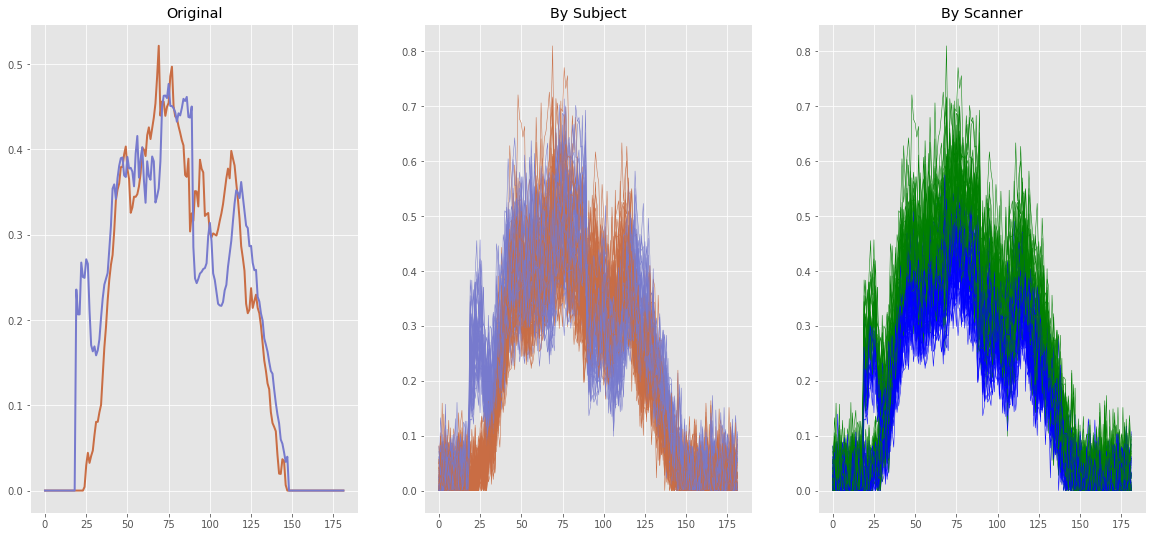

In [4]:
figsize(20, 9)
subcols = ["#c96d44", "#777acd"]
scancols = ["blue", "green"]

plt.style.use('ggplot')
plt.subplot(131)   
X = np.arange(0, profiles.shape[1])
plt.plot(X, subject1, c=subcols[0], lw=2)
plt.plot(X, subject2, c=subcols[1], lw=2)
plt.title("Original")

plt.subplot(132)   
X = np.arange(0, profiles.shape[1])
for i in range(len(profiles)):
    plt.plot(X, profiles[i], c=subcols[subject_source[i]], lw=0.5)
    plt.title("By Subject")
 
plt.subplot(133)  
X = np.arange(0, profiles.shape[1])
for i in range(len(profiles)):
    plt.plot(X, profiles[i], c=scancols[scanner_source[i]], lw=.5)
    plt.title("By Scanner")

plt.savefig("dist.png")

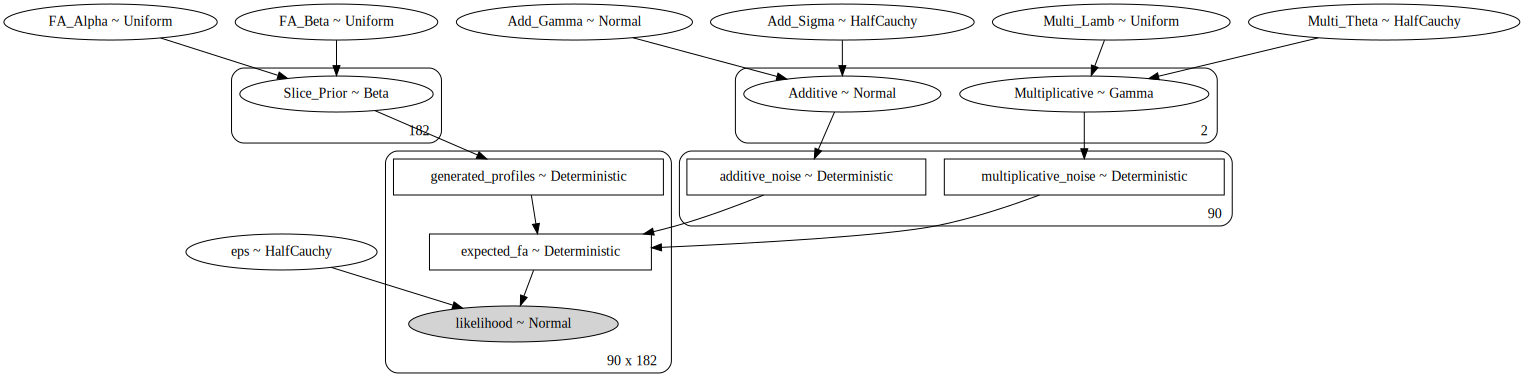

In [16]:
## Estimate distribution
  #priors 

scanners = 2
add_mu_prior_mu = 0.0
add_mu_prior_sigma = 0.1
 
with pm.Model() as model: 
    
    #FA Value prior
    fa_alpha = pm.Uniform("FA_Alpha", 0, 100)    
    fa_beta = pm.Uniform("FA_Beta", 0, 100)    
    
   # Beta(1,1) is equivalent to uniform  
    slice_prior = pm.Beta("Slice_Prior", fa_alpha, fa_beta, shape=profiles.shape[1])
       
    add_mu = pm.Normal("Add_Gamma", add_mu_prior_mu, add_mu_prior_sigma)
  
    add_sigma = pm.HalfCauchy("Add_Sigma", beta=1)
  
    additive = pm.Normal("Additive", add_mu, sigma=add_sigma, shape=scanners)   

    multi_lamb = pm.Uniform("Multi_Lamb", 0, 100)
  
    multi_theta = pm.HalfCauchy("Multi_Theta", beta=0.5) 
  
    multiplicative = pm.Gamma("Multiplicative", mu=multi_lamb, sigma=multi_theta, shape=scanners)  
     
    generated_profiles = pm.Deterministic("generated_profiles", slice_prior * np.ones(profiles.shape))   
        
    additive_noise = pm.Deterministic("additive_noise", additive[scanner_source])
    
    multiplicative_noise = pm.Deterministic("multiplicative_noise", multiplicative[scanner_source])
    
    #expected value
    expected_fa = pm.Deterministic("expected_fa", generated_profiles * multiplicative_noise.reshape((profiles.shape[0],1)) + additive_noise.reshape((profiles.shape[0],1)))
  
    #model error
    eps = pm.HalfCauchy('eps', beta=1)
    
    #model likelihood
    likelihood = pm.Normal("likelihood", mu=expected_fa, sigma=eps, observed=profiles) 
    
pm.model_to_graphviz(model)   

In [17]:
#model.check_test_point()
with model:
    model_trace = pm.sample(20000, tune=2000) 

 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, Multiplicative, Multi_Theta, Multi_Lamb, Additive, Add_Sigma, Add_Gamma, Slice_Prior, FA_Beta, FA_Alpha]
Sampling 4 chains: 100%|██████████| 88000/88000 [16:34<00:00, 88.51draws/s]
There were 152 divergences after tuning. Increase `target_accept` or reparameterize.
There were 127 divergences after tuning. Increase `target_accept` or reparameterize.
There were 115 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9211131489082158, but should be close to 0.8. Try to increase the number of tuning steps.
There were 115 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8793355272533897, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller t

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f168977ac50>,
      dtype=object)

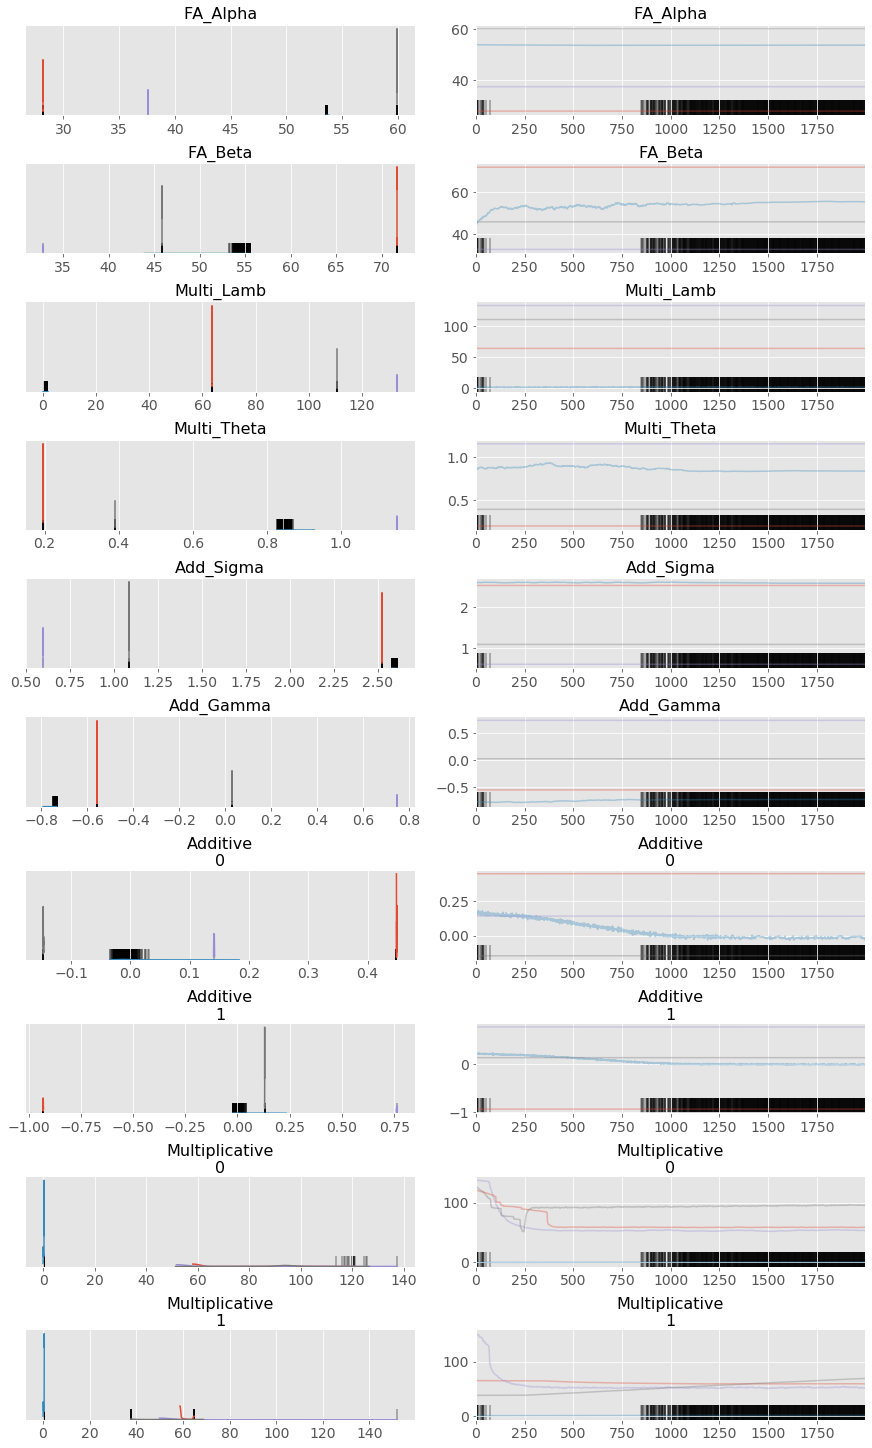

In [14]:
pm.traceplot(model_trace[:], var_names=["FA_Alpha","FA_Beta","Multi_Lamb", "Multi_Theta", "Add_Sigma", "Add_Gamma", "Additive", "Multiplicative", "multi_error", "likelihood"])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f163d491fd0>,
      dtype=object)

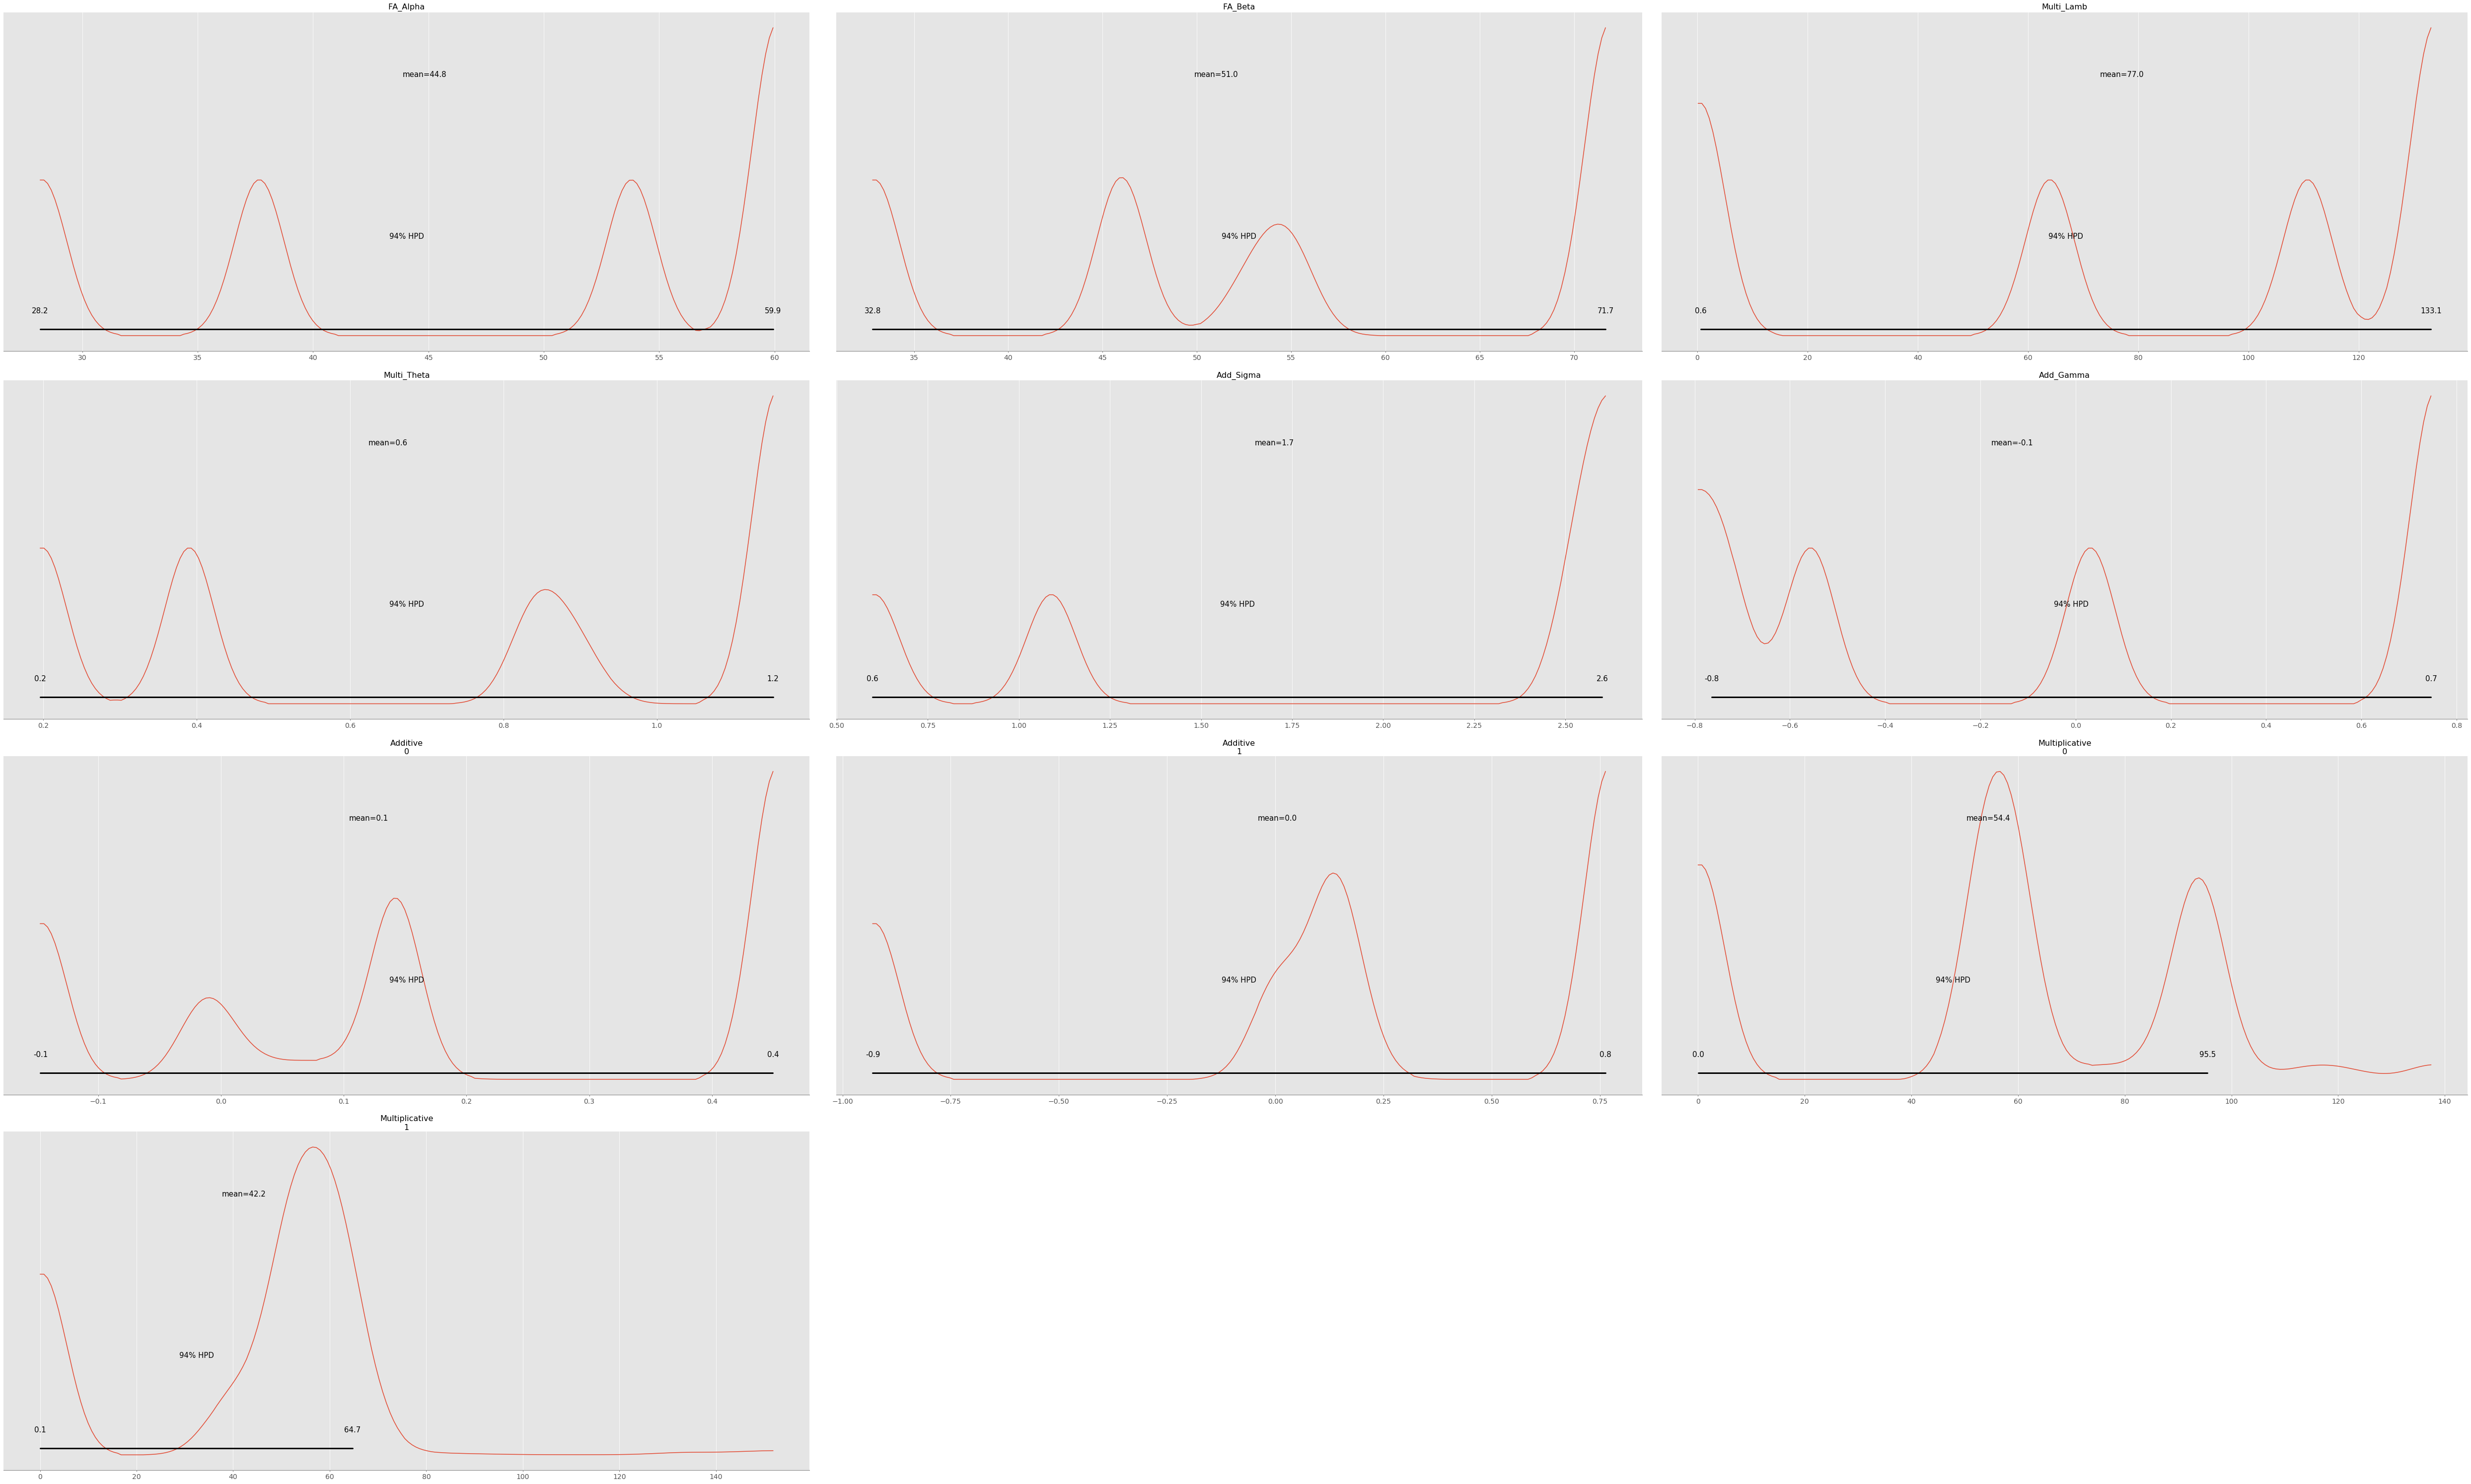

In [15]:
pm.plot_posterior(model_trace[:], var_names=["FA_Alpha","FA_Beta","Multi_Lamb", "Multi_Theta", "Add_Sigma", "Add_Gamma", "Additive", "Multiplicative", "multi_error", "likelihood"])